In [2]:
import sys
!{sys.executable} -m pip install xgboost

You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.


In [13]:
import numpy as np
import pandas as pd

import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from keras.models import Model
from keras.layers import Input, Reshape, Dot
from keras.layers.embeddings import Embedding
from keras.layers import Concatenate, Dense, Dropout
from keras.optimizers import adam_v2
from keras.regularizers import l2

/Users/sarahhan/data_folder/movie_titles.csv
/Users/sarahhan/data_folder/qualifying.txt
/Users/sarahhan/data_folder/combined_data_2.txt
/Users/sarahhan/data_folder/combined_data_3.txt
/Users/sarahhan/data_folder/combined_data_1.txt
/Users/sarahhan/data_folder/combined_data_4.txt


In [17]:
if not os.path.isfile('data.csv'):
    data = open('data.csv', mode='w')

files = ['/Users/sarahhan/data_folder/netflix-prize-data/combined_data_1.txt',
         '/Users/sarahhan/data_folder/netflix-prize-data/combined_data_2.txt',
         '/Users/sarahhan/data_folder/netflix-prize-data/combined_data_3.txt',
         '/Users/sarahhan/data_folder/netflix-prize-data/combined_data_4.txt']
for file in files:
  print("Opening file: {}".format(file))
  with open(file) as f:
    for line in f:
        line = line.strip()
        if line.endswith(':'):
            movie_id = line.replace(':', '')
        else:
            data.write(movie_id + ',' + line)
            data.write('\n')
data.close()

df = pd.read_csv('data.csv', names=['movie_id', 'user_id','rating','date'])

df

Opening file: /Users/sarahhan/data_folder/netflix-prize-data/combined_data_1.txt
Opening file: /Users/sarahhan/data_folder/netflix-prize-data/combined_data_2.txt
Opening file: /Users/sarahhan/data_folder/netflix-prize-data/combined_data_3.txt
Opening file: /Users/sarahhan/data_folder/netflix-prize-data/combined_data_4.txt


,movie_id,user_id,rating,date
0,1,1488844,3,2005-09-06
1,1,822109,5,2005-05-13
2,1,885013,4,2005-10-19
3,1,30878,4,2005-12-26
4,1,823519,3,2004-05-03
...,...,...,...,...
100480502,17770,1790158,4,2005-11-01
100480503,17770,1608708,3,2005-07-19
100480504,17770,234275,1,2004-08-07
100480505,17770,255278,4,2004-05-28


In [18]:
small_df = pd.DataFrame()

group = df.groupby('user_id')['rating'].count()
top_users = group.sort_values(ascending=False)[:10000]

group = df.groupby('movie_id')['rating'].count()
top_movies = group.sort_values(ascending=False)[:2000]

small_df = df.join(top_users, rsuffix='_r', how='inner', on='user_id')
small_df = small_df.join(top_movies, rsuffix='_r', how='inner', on='movie_id')

user_enc = LabelEncoder()
small_df['user'] = user_enc.fit_transform(small_df['user_id'].values)
movie_enc = LabelEncoder()
small_df['movie'] = movie_enc.fit_transform(small_df['movie_id'].values)

n_movies = small_df['movie'].nunique()
n_users = small_df['user'].nunique()
small_df

,movie_id,user_id,rating,date,rating_r,rating_r,user,movie
5149,8,1488844,4,2005-05-12,2206,14910,5591,0
5883,8,1227322,5,2005-05-31,4752,14910,4587,0
6183,8,525356,4,2005-08-26,4913,14910,1944,0
6310,8,401047,2,2005-06-15,2119,14910,1465,0
7140,8,883478,5,2005-10-10,3222,14910,3259,0
...,...,...,...,...,...,...,...,...
45663998,8163,778937,3,2005-06-10,1284,12553,2874,914
45668920,8163,1230845,3,2005-02-18,1277,12553,4603,914
45670283,8163,733887,4,2005-01-04,1779,12553,2701,914
45666732,8163,1645937,3,2005-02-01,1106,12553,6176,914


In [19]:
X = small_df[['user', 'movie']].values
y = small_df['rating'].values

X_training, X_test, y_training, y_test = train_test_split(X, y, test_size=0.1)
X_train, X_val, y_train, y_val = train_test_split(X_training, y_training, test_size=0.1)

e_dimension = 50

X_train_array = [X_train[:, 0], X_train[:, 1]]
X_val_array = [X_val[:, 0], X_val[:, 1]]
X_test_array = [X_test[:, 0], X_test[:, 1]]

In [23]:
user = Input(shape=(1,))
u = Embedding(n_users, e_dimension, embeddings_initializer='he_normal',
              embeddings_regularizer=l2(1e-6))(user)
u = Reshape((e_dimension,))(u)
movie = Input(shape=(1,))
m = Embedding(n_movies, e_dimension, embeddings_initializer='he_normal',
              embeddings_regularizer=l2(1e-6))(movie)
m = Reshape((e_dimension,))(m)

x = Dot(axes=1)([u, m])
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(1)(x)
model = Model(inputs=[user, movie], outputs=x)
model.compile(loss='mean_squared_error', 
              optimizer=adam_v2.Adam(lr=0.001), 
              metrics=[tf.keras.metrics.RootMeanSquaredError()]
              )

callbacks_list = [keras.callbacks.EarlyStopping(monitor='val_loss',
                                                patience=1,
                                                ),
                  keras.callbacks.ModelCheckpoint(  
                      filepath='Model_1',
                      monitor='val_loss',
                      save_best_only=True,
                      )]

model.summary()  

history = model.fit(x=X_train_array, y=y_train, batch_size=64, epochs=20,
                    verbose=1, 
                    callbacks=callbacks_list,
                    validation_data=(X_val_array, y_val)
                    )
model.save("Model_1")

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_6 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 embedding_4 (Embedding)        (None, 1, 50)        500000      ['input_5[0][0]']                
                                                                                                  
 embedding_5 (Embedding)        (None, 1, 50)        100000      ['input_6[0][0]']                
                                                                                            

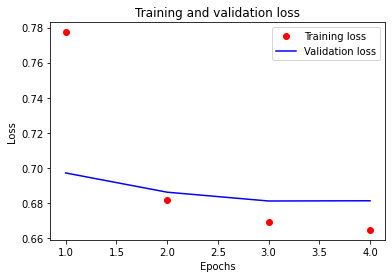

In [24]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)

plt.plot(epochs, loss_values, 'ro', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [25]:
m = tf.keras.metrics.RootMeanSquaredError()
m.update_state(model.predict(X_test_array), y_test)
m.result().numpy()

0.7889736

In [29]:
small_df.to_csv('/Users/sarahhan/small_df.csv')